In [6]:
from kan import KAN

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import *

In [2]:
dataset_path = 'output_folder'

In [3]:
transform = transforms.Compose(
    [transforms.Resize(size = (220,220)),
     transforms.RandomRotation(degrees=20),
     transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.5], std=[0.5])
    ]
)

In [4]:
dataset = datasets.ImageFolder(dataset_path, transform = transform)

In [5]:
print("Informações sobre o Dataset: \n\n", dataset)
print("\nRótulos: ", dataset.class_to_idx)

Informações sobre o Dataset: 

 Dataset ImageFolder
    Number of datapoints: 24
    Root location: output_folder
    StandardTransform
Transform: Compose(
               Resize(size=(220, 220), interpolation=bilinear, max_size=None, antialias=True)
               RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
               RandomAffine(degrees=[0.0, 0.0], translate=(0.1, 0.1), scale=(0.9, 1.1), shear=[-10.0, 10.0])
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )

Rótulos:  {'Inliers': 0, 'Outliers': 1}


In [7]:
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [12]:
train_loader = DataLoader(train_dataset, batch_size=train_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_size, shuffle=True)

In [14]:
train_data = []
train_targets = []

for batch_data_train, batch_targets_train in train_loader:
    train_data.append(batch_data_train)
    train_targets.append(batch_targets_train)

train_data = torch.cat(train_data, dim=0)
train_targets = torch.cat(train_targets, dim=0)

In [15]:
test_data = []
test_targets = []

for batch_data_test, batch_targets_test in test_loader:
    test_data.append(batch_data_test)
    test_targets.append(batch_targets_test)

test_data = torch.cat(test_data, dim=0)
test_targets = torch.cat(test_targets, dim=0)

In [16]:
dataset = {}

dataset['train_input'] = train_data.view(-1, 220*220*3)
dataset['test_input'] = test_data.view(-1, 220*220*3)
dataset['train_label'] = train_targets
dataset['test_label'] = test_targets

In [17]:
model = KAN(width=[dataset['train_input'].shape[1], 100, 2], grid=3, k=3, base_fun=torch.nn.ReLU(), auto_save=False)

In [18]:
dtype = torch.get_default_dtype()

def train_acc():
    return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).type(dtype))

def test_acc():
    return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).type(dtype))

In [19]:
results = model.fit(dataset, opt="Adam", steps=50, metrics=(train_acc, test_acc), 
                    loss_fn=torch.nn.CrossEntropyLoss(), lr=0.001, batch=4)

| train_loss: 0.00e+00 | test_loss: 0.00e+00 | reg: 1.70e+04 | : 100%|█| 50/50 [24:24<00:00, 29.29s/


In [20]:
print("Acurácia dos dados de treino: ", results['train_acc'][-1])
print("Acurácia dos dados de teste: ", results['test_acc'][-1])

Acurácia dos dados de treino:  1.0
Acurácia dos dados de teste:  1.0


Text(0.5, 0.98, 'Treinamento')

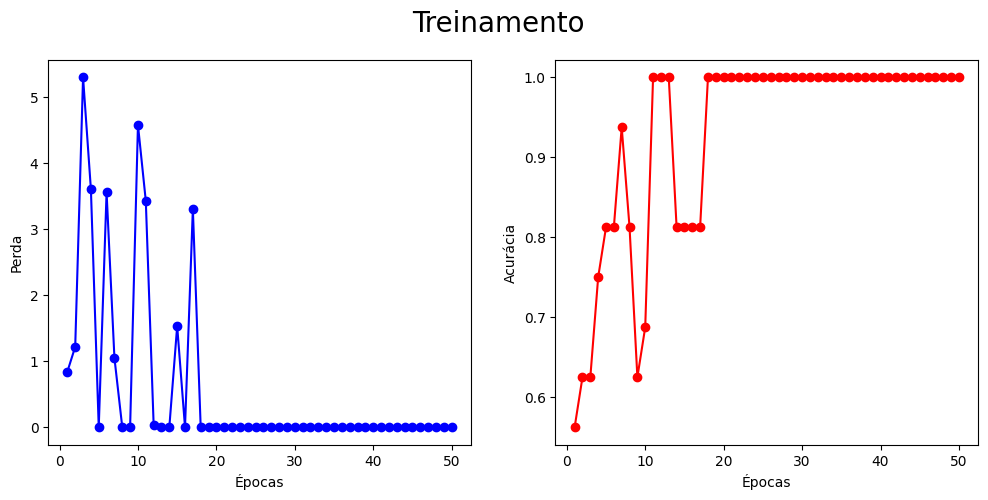

In [21]:
epochs = range(1, 51)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, results['train_loss'], 'bo-')
plt.xlabel('Épocas')
plt.ylabel('Perda')

plt.subplot(1, 2, 2)
plt.plot(epochs, results['train_acc'], 'ro-')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')

plt.suptitle("Treinamento", fontsize = 20)

Text(0.5, 0.98, 'Teste')

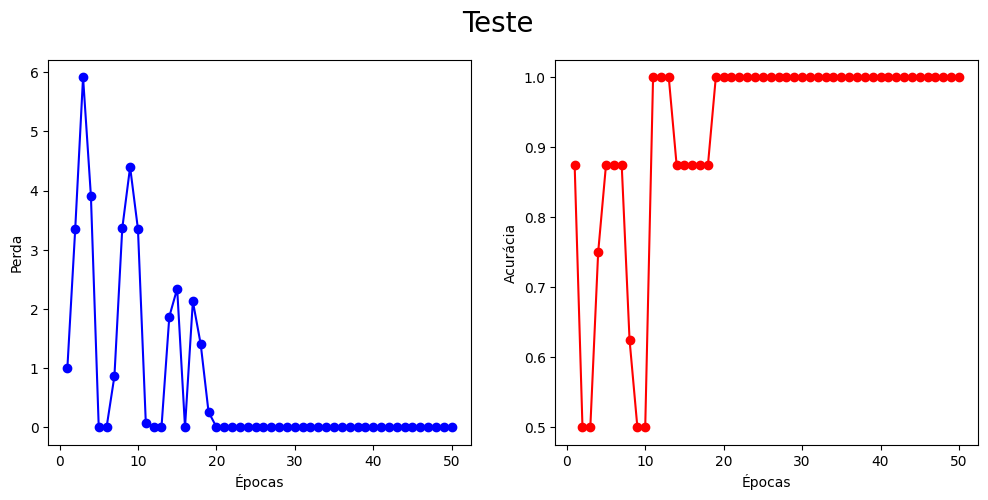

In [22]:
epochs = range(1, 51)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, results['test_loss'], 'bo-')
plt.xlabel('Épocas')
plt.ylabel('Perda')

plt.subplot(1, 2, 2)
plt.plot(epochs, results['test_acc'], 'ro-')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')

plt.suptitle("Teste", fontsize = 20)

In [24]:
rot_array = []
predt_array = []

model.eval()
    
with torch.no_grad():
        
    for images, labels in test_loader:
        images = images.view(-1, 220*220*3)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        rot_array.extend(labels.cpu().detach().numpy())
        predt_array.extend(predicted.cpu().detach().numpy())

print("!!!Teste finalizado!!!")

!!!Teste finalizado!!!


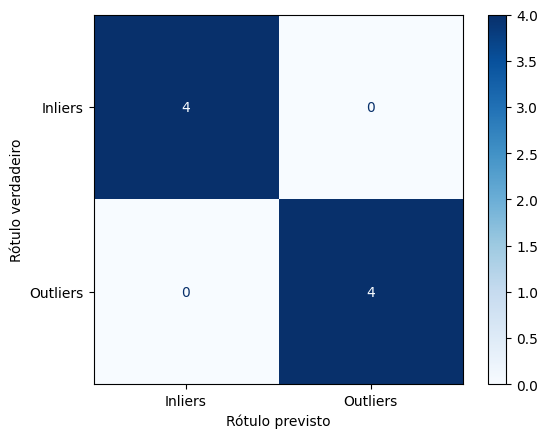

In [26]:
cm = confusion_matrix(rot_array, predt_array)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Inliers', 'Outliers'])
disp.plot(cmap=plt.cm.Blues)

plt.xlabel('Rótulo previsto')
plt.ylabel('Rótulo verdadeiro')
plt.show()

In [27]:
acc = accuracy_score(rot_array, predt_array)
print(f"Acurácia: {acc * 100 :.2f}%")

Acurácia: 100.00%


In [28]:
precision = precision_score(rot_array, predt_array, average='weighted')
print(f"Precisão: {precision * 100 :.2f}%")

Precisão: 100.00%


In [29]:
recall = recall_score(rot_array, predt_array, average='weighted')
print(f"Recall: {recall * 100 :.2f}%")

Recall: 100.00%


In [30]:
f1 = f1_score(rot_array, predt_array, average='weighted')
print(f"F1 Score: {f1 * 100 :.2f}%")

F1 Score: 100.00%
